In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from skimage.morphology import skeletonize
from scipy.spatial import cKDTree
import random
import requests
import itertools
import time

# Function to find the smallest cosine similarity
def smallest_cosine_similarity(vectors):
    smallest_similarity = float('inf')
    smallest_pair = None

    # Generate all combinations of two vectors
    for (key1, vec1), (key2, vec2) in itertools.combinations(vectors.items(), 2):
        # Compute cosine similarity as the dot product (vectors are normalized)
        similarity = similarity = np.dot(vec1[0], vec2[0])

        # Check if this is the smallest similarity so far
        if similarity < smallest_similarity:
            smallest_similarity = similarity
            smallest_pair = (key1, key2)

    return smallest_similarity, smallest_pair

def get_neighbors(x, y, shape):
    """Get valid 8-neighbor coordinates for (x, y) within the image bounds."""
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < shape[0] and 0 <= ny < shape[1]:
                neighbors.append((nx, ny))
    return neighbors

def classify_pixels(skel_img):
    """
    Classify skeleton pixels into endpoints, branch points, and regular points.
    A pixel is:
    - Endpoint if it has exactly 1 neighbor.
    - Branch point if it has 3 or more neighbors.
    - Otherwise, it's a regular chain point.
    """
    endpoints = []
    branch_points = []
    regular_points = []

    # Identify all skeleton pixels
    skel_pixels = np.argwhere(skel_img > 0)

    # Map coordinates to check neighbors efficiently
    skel_set = set(tuple(p) for p in skel_pixels)

    for x, y in skel_pixels:
        neighbors = [(nx, ny) for nx, ny in get_neighbors(x, y, skel_img.shape) if (nx, ny) in skel_set]
        count = len(neighbors)
        if count == 1:
            endpoints.append((x, y))
        elif count >= 3:
            branch_points.append((x, y))
        else:
            regular_points.append((x, y))

    return endpoints, branch_points, regular_points, skel_set

def extract_edges(skel_img):
    """
    Extract edges from a skeleton image by tracing from endpoints and branch points.
    Each edge is a list of coordinates [(x1, y1), (x2, y2), ...].
    """
    endpoints, branch_points, regular_points, skel_set = classify_pixels(skel_img)

    # To ensure each pixel is used once in building edges, keep track of visited pixels
    visited = set()

    edges = []

    # Combine endpoints and branch_points as potential start points.
    # We will attempt to trace edges starting from these points.
    # Note: Regular points can also form edges if no endpoints exist,
    # but typically edges are defined between endpoints and/or branch points.
    start_points = endpoints + branch_points

    for start in start_points:
        if start in visited:
            continue

        # From the start point, we try to walk the skeleton.
        # We need to handle different scenarios:
        # 1. Endpoint: expect to walk until we find a branch or another endpoint.
        # 2. Branch point: might branch out multiple times, but we just start one edge per branch direction.

        # Find neighbors that lead us forward (we might have multiple if it's a branch)
        neighbors = [(nx, ny) for nx, ny in get_neighbors(start[0], start[1], skel_img.shape) if (nx, ny) in skel_set]
        # If it's an endpoint, we should have exactly one neighbor to follow.
        # If it's a branch point, we will follow each neighbor as a start of a new edge, if not visited.

        for next_pixel in neighbors:
            if next_pixel in visited:
                continue

            # Trace the line segment from start to next_pixel
            edge = [start]
            current = next_pixel
            previous = start

            while True:
                edge.append(current)
                visited.add(current)

                # Find the next pixel in the chain
                nbrs = [(nx, ny) for nx, ny in get_neighbors(current[0], current[1], skel_img.shape)
                        if (nx, ny) in skel_set and (nx, ny) != previous]

                if len(nbrs) == 0:
                    # Dead end - should not happen if skeleton is well-formed
                    break
                elif len(nbrs) > 1:
                    # We've hit a branch point. Stop here.
                    break
                else:
                    # len(nbrs) == 1
                    next_pixel = nbrs[0]
                    # Check if this next_pixel is an endpoint or branch point
                    # If it is, this edge ends here.
                    if next_pixel in endpoints or next_pixel in branch_points:
                        edge.append(next_pixel)
                        visited.add(next_pixel)
                        break
                    # Otherwise, continue the chain
                    previous, current = current, next_pixel
                    continue

            if len(edge) > 1:
                edges.append(np.array(edge).reshape(-1, 1, 2))

    return edges

def anisotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    r"""
    Edge-preserving, XD Anisotropic diffusion.

    To achieve the best effects, the image should be scaled to
    values between 0 and 1 beforehand.


    Parameters
    ----------
    img : array_like
        Input image (will be cast to numpy.float).
    niter : integer
        Number of iterations.
    kappa : integer
        Conduction coefficient, e.g. 20-100. ``kappa`` controls conduction
        as a function of the gradient. If ``kappa`` is low small intensity
        gradients are able to block conduction and hence diffusion across
        steep edges. A large value reduces the influence of intensity gradients
        on conduction.
    gamma : float
        Controls the speed of diffusion. Pick a value :math:`<= .25` for stability.
    voxelspacing : tuple of floats or array_like
        The distance between adjacent pixels in all img.ndim directions
    option : {1, 2, 3}
        Whether to use the Perona Malik diffusion equation No. 1 or No. 2,
        or Tukey's biweight function.
        Equation 1 favours high contrast edges over low contrast ones, while
        equation 2 favours wide regions over smaller ones. See [1]_ for details.
        Equation 3 preserves sharper boundaries than previous formulations and
        improves the automatic stopping of the diffusion. See [2]_ for details.

    Returns
    -------
    anisotropic_diffusion : ndarray
        Diffused image.

    Notes
    -----
    Original MATLAB code by Peter Kovesi,
    School of Computer Science & Software Engineering,
    The University of Western Australia,
    pk @ csse uwa edu au,
    <http://www.csse.uwa.edu.au>

    Translated to Python and optimised by Alistair Muldal,
    Department of Pharmacology,
    University of Oxford,
    <alistair.muldal@pharm.ox.ac.uk>

    Adapted to arbitrary dimensionality and added to the MedPy library Oskar Maier,
    Institute for Medical Informatics,
    Universitaet Luebeck,
    <oskar.maier@googlemail.com>

    June 2000  original version. -
    March 2002 corrected diffusion eqn No 2. -
    July 2012 translated to Python -
    August 2013 incorporated into MedPy, arbitrary dimensionality -

    References
    ----------
    .. [1] P. Perona and J. Malik.
       Scale-space and edge detection using ansotropic diffusion.
       IEEE Transactions on Pattern Analysis and Machine Intelligence,
       12(7):629-639, July 1990.
    .. [2] M.J. Black, G. Sapiro, D. Marimont, D. Heeger
       Robust anisotropic diffusion.
       IEEE Transactions on Image Processing,
       7(3):421-432, March 1998.
    """
    # define conduction gradients functions
    if option == 1:

        def condgradient(delta, spacing):
            return np.exp(-((delta / kappa) ** 2.0)) / float(spacing)

    elif option == 2:

        def condgradient(delta, spacing):
            return 1.0 / (1.0 + (delta / kappa) ** 2.0) / float(spacing)

    elif option == 3:
        kappa_s = kappa * (2**0.5)

        def condgradient(delta, spacing):
            top = 0.5 * ((1.0 - (delta / kappa_s) ** 2.0) ** 2.0) / float(spacing)
            return np.where(np.abs(delta) <= kappa_s, top, 0)

    # initialize output array
    out = np.array(img, dtype=np.float32, copy=True)

    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.0] * img.ndim)

    # initialize some internal variables
    deltas = [np.zeros_like(out) for _ in range(out.ndim)]

    for _ in range(niter):
        # calculate the diffs
        for i in range(out.ndim):
            slicer = tuple(
                [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            )
            deltas[i][tuple(slicer)] = np.diff(out, axis=i)

        # update matrices
        matrices = [
            condgradient(delta, spacing) * delta
            for delta, spacing in zip(deltas, voxelspacing)
        ]

        # subtract a copy that has been shifted ('Up/North/West' in 3D case) by one
        # pixel. Don't as questions. just do it. trust me.
        for i in range(out.ndim):
            slicer = tuple(
                [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            )
            matrices[i][tuple(slicer)] = np.diff(matrices[i], axis=i)

        # update the image
        out += gamma * (np.sum(matrices, axis=0))

    return out

def iterative_prune(skel_img, size):
    """Iteratively remove endpoints (tips) from a skeletonized image."""
    def find_tips(skel_img):
        kernel = np.array([[1, 1, 1], [1, 10, 1], [1, 1, 1]], dtype=np.uint8)
        neighbors = cv2.filter2D(skel_img, -1, kernel)
        tips = (neighbors == 11).astype(np.uint8) * 255
        return tips

    pruned_img = skel_img.copy()
    for _ in range(size):
        endpoints = find_tips(pruned_img)
        pruned_img = cv2.subtract(pruned_img, endpoints)

    return pruned_img

def fast_prune(skel_img, size=5):
    pruned_img = skel_img.copy()
    contours, _ = cv2.findContours(skel_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    kept_segments = []
    deleted_segments = []

    for contour in contours:
        arc_length = cv2.arcLength(contour, closed=False)  # Arc length
        point_count = len(contour)  # Number of points

        # Check BOTH conditions: minimum points and arc length
        if point_count > size and arc_length > size:
            kept_segments.append(contour)  # Keep valid contours
        else:
            deleted_segments.append(contour)  # Remove invalid contours
            # Remove small segments from the skeleton
            for point in contour:
                pruned_img[point[0][1], point[0][0]] = 0

    pruned_img = iterative_prune(pruned_img, size)  # Optional extra pruning
    print(f"Removed {len(deleted_segments)} small contours (less than {size} points or arc length)")
    return pruned_img, kept_segments

def find_branch_points(skel_img):
    """Identify branch points in a skeletonized image.

    Inputs:
    - skel_img: Binary skeletonized image (0 and 255 values).

    Returns:
    - branch_pts_img: Binary image with branch points marked as 255, rest as 0.
    """
    # Define the branch point detection kernels
    t1 = np.array([[-1, 1, -1],
                   [1, 1, 1],
                   [-1, -1, -1]])
    t2 = np.array([[1, -1, 1],
                   [-1, 1, -1],
                   [1, -1, -1]])
    y1 = np.array([[1, -1, 1],
                   [0, 1, 0],
                   [0, 1, 0]])
    y2 = np.array([[-1, 1, -1],
                   [1, 1, 0],
                   [-1, 0, 1]])

    # Rotate the kernels to cover all orientations
    kernels = [t1, t2, y1, y2]
    for _ in range(3):
        kernels += [np.rot90(kernel) for kernel in kernels[-4:]]

    # Create an empty image to store branch points
    branch_pts_img = np.zeros(skel_img.shape, dtype=np.uint8)

    # Apply each kernel with morphological hit-or-miss operation
    for kernel in kernels:
        hit_miss = cv2.morphologyEx(skel_img, cv2.MORPH_HITMISS, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        branch_pts_img = cv2.bitwise_or(branch_pts_img, hit_miss)

    return branch_pts_img

# Union-Find Helper Functions
class UnionFind:
    def __init__(self):
        self.parent = {}

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  # Path compression
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x != root_y:
            self.parent[root_y] = root_x

def merge_edges(edge_points_list, branch_connections):
    if not branch_connections:
        return edge_points_list

    # Initialize Union-Find
    uf = UnionFind()
    for edges in branch_connections.values():
        for i in range(len(edges) - 1):
            # Use edges directly as tuples (no reshape needed)
            edge1 = edges[i]
            edge2 = edges[i + 1]
            uf.union(edge1, edge2)

    grouped_edges = {}
    for idx, edge in enumerate(edge_points_list):
        root = uf.find(idx)
        if root not in grouped_edges:
            grouped_edges[root] = []
        grouped_edges[root].append(edge)

    new_edge_objects = []
    for group_edges in grouped_edges.values():
        # Ensure edge continuity during concatenation
        concatenated = group_edges[0]
        for next_edge in group_edges[1:]:
            if np.linalg.norm(concatenated[-1] - next_edge[0]) > 1:  # Enforce continuity
                next_edge = np.flip(next_edge, axis=0)  # Reverse if needed
            concatenated = np.vstack((concatenated, next_edge))

        sorted_edge = sort_by_proximity(concatenated)  # Sort for good measure
        new_edge_objects.append(sorted_edge.reshape(-1, 1, 2))

    return new_edge_objects

def ensure_minimum_distance_at_ends(edge_points, branch_point):
    """
    Ensures that the point with the minimum distance to a branch point is at the start or end of the edge points.

    Parameters:
        edge_points (numpy.ndarray): Array of points representing the edge, of shape (n, 1, 2).
        branch_point (numpy.ndarray): The branch point [x, y] to compare distances to.

    Returns:
        numpy.ndarray: Rearranged edge points with the closest point to the branch at the start or end.
    """
    edge_points = edge_points.reshape(-1, 2)  # Ensure (n, 2) shape for processing
    distances = np.linalg.norm(edge_points - branch_point, axis=1)
    min_idx = np.argmin(distances)

    # Check if closest point is already at the start or end
    if min_idx == 0 or min_idx == len(edge_points) - 1:
        return edge_points.reshape(-1, 1, 2)  # Return as is if already sorted

    # Rotate the list so the closest point is at the start
    if min_idx < len(edge_points) // 2:
        # Rotate to bring closest point to the beginning
        sorted_points = np.roll(edge_points, -min_idx, axis=0)
    else:
        # Rotate to bring closest point to the end
        sorted_points = np.roll(edge_points, len(edge_points) - min_idx - 1, axis=0)

    return sorted_points.reshape(-1, 1, 2)

def sort_by_proximity(contour_points):
    """
    Sorts a list of points (from cv2.findContours) to minimize the distance between neighboring points in the sorted order.

    Parameters:
        contour_points (numpy.ndarray): Array of points of shape (n, 1, 2) as returned by cv2.findContours.

    Returns:
        numpy.ndarray: Sorted array of points of shape (n, 1, 2) with minimal distance between neighbors.
    """
    # Reshape contour points to (n, 2) for processing if needed
    if contour_points.ndim == 3:
        contour_points = contour_points.reshape(-1, 2)

    # Remove duplicate points
    contour_points = np.unique(contour_points, axis=0)

    sorted_points = [contour_points[0]]  # Start with the first point
    contour_points = np.delete(contour_points, 0, axis=0)  # Remove it from the list

    while len(contour_points) > 0:
        # Find the nearest point to the last point in sorted_points
        last_point = sorted_points[-1]
        distances = np.linalg.norm(contour_points - last_point, axis=1)
        nearest_idx = np.argmin(distances)
        sorted_points.append(contour_points[nearest_idx])
        contour_points = np.delete(contour_points, nearest_idx, axis=0)

    # Return the sorted points as an array of shape (n, 1, 2)
    return np.array(sorted_points).reshape(-1, 1, 2)

def draw_edge_objects(edge_objects, image_shape, thickness=2):
    """
    Draw edge objects on a blank image with color based on arc length.

    Parameters:
        edge_objects (list): List of edge objects (contours).
        image_shape (tuple): Shape of the image to draw on.
        thickness (int): Line thickness for drawing the edges.

    Returns:
        color_image: Image with edges drawn using a color scale based on length.
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm  # For colormap
    from matplotlib.colors import Normalize

    # Compute arc lengths
    arc_lengths = [cv2.arcLength(edge, closed=False) for edge in edge_objects]

    # Normalize arc lengths to range [0, 1]
    norm = Normalize(vmin=min(arc_lengths), vmax=max(arc_lengths))
    colormap = cm.plasma  # Choose a colorful colormap ('plasma', 'viridis', 'inferno', etc.)

    # Create a blank image
    color_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)

    # Draw each edge with color based on its normalized arc length
    for edge, length in zip(edge_objects, arc_lengths):
        color_value = colormap(norm(length))  # Get RGBA color from the colormap
        color = tuple(map(int, np.array(color_value[:3]) * 255))  # Ensure integers in the tuple
        cv2.polylines(color_image, [edge], isClosed=False, color=color, thickness=thickness, lineType=cv2.LINE_AA)

    return color_image

# Combined Density Plot and Histogram
def plot_density_histogram(data, ax):
    sns.histplot(data, bins=20, ax=ax, kde=True, color='steelblue', edgecolor='black')
    ax.set_title("Density and Histogram of Arc Lengths")
    ax.set_xlabel("Arc Length")
    ax.set_ylabel("Density / Frequency")

# Boxplot
def plot_boxplot(data, ax):
    sns.boxplot(data=data, ax=ax, color='lightblue')
    ax.set_title("Boxplot of Arc Lengths")
    ax.set_xlabel("Arc Length")

# Updated Visualization
def visualize_results(fib_image, skeletonized_img1, blurred_img, color_image, arc_lengths):
    fig, axes = plt.subplots(3, 2, figsize=(20, 20), constrained_layout=True)

    # Plot Original Image
    axes[0, 0].imshow(fib_image, cmap='gray')
    axes[0, 0].set_title("Original Image")

    # Plot Skeletonized Image
    axes[0, 1].imshow(skeletonized_img1, cmap='gray')
    axes[0, 1].set_title("Skeletonized Image (Linewidth Approx.)")

    # Plot Blurred Image
    axes[1, 0].imshow(blurred_img, cmap='gray')
    axes[1, 0].set_title("Blurred Image")

    # Plot Final Colored Image
    axes[1, 1].imshow(color_image)
    axes[1, 1].set_title("Final Colored Edge Network")

    # Combined Density and Histogram Plot
    plot_density_histogram(arc_lengths, axes[2, 0])

    # Boxplot
    plot_boxplot(arc_lengths, axes[2, 1])

    # Hide unused axes (if any)
    for ax in axes.flatten():
        ax.axis('on')  # Ensure all axes are turned on
    plt.show()

def calculate_edge_connections(intersection_associations, edge_points_list, br_pts):
    """
    Calculate edge connections based on cosine similarity to identify the most aligned pair of edges.

    Args:
        intersection_associations: A dictionary mapping branch point indices to associated edge indices.
        edge_points_list: List of edge points for all edges.
        br_pts: List of branch points (x, y).

    Returns:
        branch_connections: A dictionary mapping branch point indices to the pair of connected edges.
    """

    branch_connections = {}

    for br_index, associated_edges in intersection_associations.items():
        #print(f"Branch Point {br_index} associated edges: {associated_edges}")
        vectors = {}
        smallest_pair = None
        for edge_index in associated_edges:
            edge_points = sort_by_proximity(edge_points_list[edge_index])

            # Check edge length and skip invalid ones
            if len(edge_points) < 5:
                # print(f"Skipping edge {edge_index} due to insufficient points: length={len(edge_points)}")
                continue

            last_idx = len(edge_points) - 1
            close_idx = np.argmin(np.linalg.norm(edge_points - br_pts[br_index], axis=2))

            if close_idx == 0:
                v = np.linalg.norm(edge_points[0] - edge_points[4])
                vectors[edge_index] = (edge_points[0] - edge_points[4]) / v
            elif close_idx == last_idx:
                v = np.linalg.norm(edge_points[last_idx] - edge_points[last_idx - 4])
                vectors[edge_index] = (edge_points[last_idx] - edge_points[last_idx - 4]) / v
            else:
                near_dist = np.linalg.norm(edge_points[close_idx - 1])
                far_dist = np.linalg.norm(edge_points[close_idx + 1])
                if near_dist < far_dist and close_idx >= 4:
                    v = np.linalg.norm(edge_points[close_idx] - edge_points[close_idx - 4])
                    vectors[edge_index] = (edge_points[close_idx] - edge_points[close_idx - 4]) / v
                elif close_idx + 4 < len(edge_points):
                    v = np.linalg.norm(edge_points[close_idx] - edge_points[close_idx + 4])
                    vectors[edge_index] = (edge_points[close_idx] - edge_points[close_idx + 4]) / v

        # Find the smallest cosine similarity
        smallest_similarity, smallest_pair = smallest_cosine_similarity(vectors)
        if smallest_pair:
            branch_connections[br_index] = smallest_pair
    return branch_connections

def calculate_intersection_associations(br_pts, edge_points_list, proximity_threshold=15):
    """
    Calculate intersection associations by finding nearby edges for each branch point.

    Args:
        br_pts: List of branch points (x, y).
        edge_points_list: List of edge points for all edges.
        proximity_threshold: Maximum distance for association.

    Returns:
        intersection_associations: A dictionary mapping branch point indices to associated edge indices.
    """
    intersection_associations = {}
    for br_index, br_point in enumerate(br_pts):
        associated_edges = []
        for edge_index, edge_points in enumerate(edge_points_list):
            # Ensure edge_points has shape (n, 2)
            if edge_points.ndim == 1:
                edge_points = edge_points.reshape(-1, 2)

            # Calculate distances from branch point to all points in the edge
            distances = np.linalg.norm(edge_points - br_point, axis=1)
            min_distance = np.min(distances)

            # Check proximity
            if min_distance <= proximity_threshold:
                associated_edges.append(edge_index)

        intersection_associations[br_index] = associated_edges
    return intersection_associations

def proc_img(image_data, dim= 1600):
    print("Preprocessing Image")
    start_time = time.perf_counter()
    # Decode the image and convert it to grayscale
    if len(image_data.shape) == 1:
        og_img = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)
    else:
        og_img = image_data
    # Snip off the dataribbon (later will need the dataribbon to identify scale for fiber length)
    fib_image = og_img[:3750,:]
    fib_image = fib_image[0:dim,0:dim]
    # Anisotropic diffusion first to adaptively eliminate noise while maintaining edge information
    diff_img = anisotropic_diffusion(fib_image, niter=50, kappa=20, gamma=0.1, option=1)
    # Initial thresholding cutoff in preparation for skeletonization, the second parameter will increase/decrease sensitivity
    _, thresholded_img = cv2.threshold(diff_img, 127, 255, 0)

    # Main loop for initial pass at skeletonization
    skel = np.zeros(thresholded_img.shape, np.uint8)                              # Creates blank canvas to store skeletonized image
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))                  # Generates kernel to pass through each section of image
    while True:
        open_img = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, element)     # Fit open-cross kernel to thresholded image
        temp = cv2.subtract(thresholded_img, open_img)                            # Subtracts the above from the original image
        temp = temp.astype(skel.dtype)                                            # Convert temp from 32-bit to 8bit datatype
        skel = cv2.bitwise_or(skel, temp)                                         # aggregates and compares both original and above created image
        thresholded_img = cv2.erode(thresholded_img, element)                     # degrades the width of the image by 1 pixel
        if cv2.countNonZero(thresholded_img) == 0:                                # conditional exits if there are no more remaining iterations to pass through
            break
    skeletonized_img1 = skel.copy()

    # Gaussian blur using 25x25 kernel
    blurred_img = cv2.GaussianBlur(skel, (25, 25), 0)
    # Very light noise removal (using 15 instead of 127 above here)
    _, bin_img = cv2.threshold(blurred_img, 15, 255, cv2.THRESH_BINARY)
    # Use standard skeletonization from cv2 package and convert final image output.
    skeletonized_img2 = skeletonize(bin_img // 255).astype(np.uint8) * 255
    end_time = time.perf_counter()
    print(f"Time Elapsed: {end_time - start_time:.4f} sec")

    print("Finding branch points")
    start_time = time.perf_counter()
    branch_pts_img = find_branch_points(skeletonized_img2)
    branch_pts = np.argwhere(branch_pts_img != 0)
    # Create a kernel for dilation (3x3 kernel in this example, adjust as needed)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Apply dilation using the kernel
    bp = cv2.dilate(branch_pts_img, kernel, iterations=1)
    branch_pts = np.array([[pt[1], pt[0]] for pt in branch_pts])  # Convert from [y, x]
    end_time = time.perf_counter()
    print(f"Time Elapsed: {end_time - start_time:.4f} sec")

    print("Finding edge segments")
    start_time = time.perf_counter()
    # Subtract from the skeleton so that leaves are no longer connected
    segments = cv2.subtract(skeletonized_img2, bp)

    # Segmentation function that also will remove identified objects less than size specified.
    pruned_skel, edge_objects = fast_prune(segments)
    # Explicitly ensure all edges have at least 5 points
    edge_objects = [edge for edge in edge_objects if len(edge) >= 5]
    edge_points_list = [np.array([point[0] for point in edge]) for edge in edge_objects]
    edge_points_list = [edge for edge in edge_points_list if len(edge) >= 5]  # Double-check filtering

    # print(f"Branch Points: {branch_pts}")
    # print(f"Number of Edges: {len(edge_points_list)}")
    # for i, edge in enumerate(edge_points_list):
    #     print(f"Edge {i}: {edge.shape} points")

    end_time = time.perf_counter()
    print(f"Time Elapsed: {end_time - start_time:.4f} sec")

    print("Finding Intersection to Edge Associations")
    start_time = time.perf_counter()

    # Step 1: Calculate Edge to Intersection Associations
    intersection_associations = calculate_intersection_associations(br_pts=branch_pts,
                                                    edge_points_list=edge_points_list,
                                                    proximity_threshold=5
                                                )

    end_time = time.perf_counter()
    print(f"Time Elapsed: {end_time - start_time:.4f} sec")

    print("Deciding which edges to merge")
    start_time = time.perf_counter()

    # Step 2: Build `branch_connections`
    branch_connections = calculate_edge_connections(intersection_associations,
                                                    edge_points_list, branch_pts)

    end_time = time.perf_counter()
    print(f"Time Elapsed: {end_time - start_time:.4f} sec")

    print("Merging Edges")
    start_time = time.perf_counter()

    # Step 3: Merge Edges
    new_edge_objects = merge_edges(edge_points_list, branch_connections)

    end_time = time.perf_counter()
    print(f"Time Elapsed: {end_time - start_time:.4f} sec")

    print(f"Creating Visualization and calculating {len(new_edge_objects)} arc lengths")
    start_time = time.perf_counter()

    # Step 4: Generate Visualization
    color_image = draw_edge_objects(new_edge_objects, image_shape=pruned_skel.shape, thickness=2)
    arc_lengths = [cv2.arcLength(edge, closed=False) for edge in new_edge_objects]

    visualize_results(
        fib_image=fib_image,
        skeletonized_img1=skeletonized_img1,
        blurred_img=blurred_img,
        color_image=color_image,
        arc_lengths=arc_lengths
    )

    # Print stats and return results
    print("Number of branch points:", len(branch_pts))
    print("Number of Intersection Associations:", len(intersection_associations))
    print("Number of Branch Connections: ", len(branch_connections))
    print("Average Fiber Length:", np.mean(arc_lengths))

    return pruned_skel, edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image

# USE FOR TIFF IMAGES

In [14]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 3750)

# USE FOR PNG IMAGES

Preprocessing Image
Time Elapsed: 0.2432 sec
Finding branch points
Time Elapsed: 0.0056 sec
Finding edge segments
Removed 0 small contours (less than 5 points or arc length)
Time Elapsed: 0.0079 sec
Finding Intersection to Edge Associations
Time Elapsed: 0.0004 sec
Deciding which edges to merge
Time Elapsed: 0.0056 sec
Merging Edges
Time Elapsed: 0.0108 sec
Creating Visualization and calculating 4 arc lengths


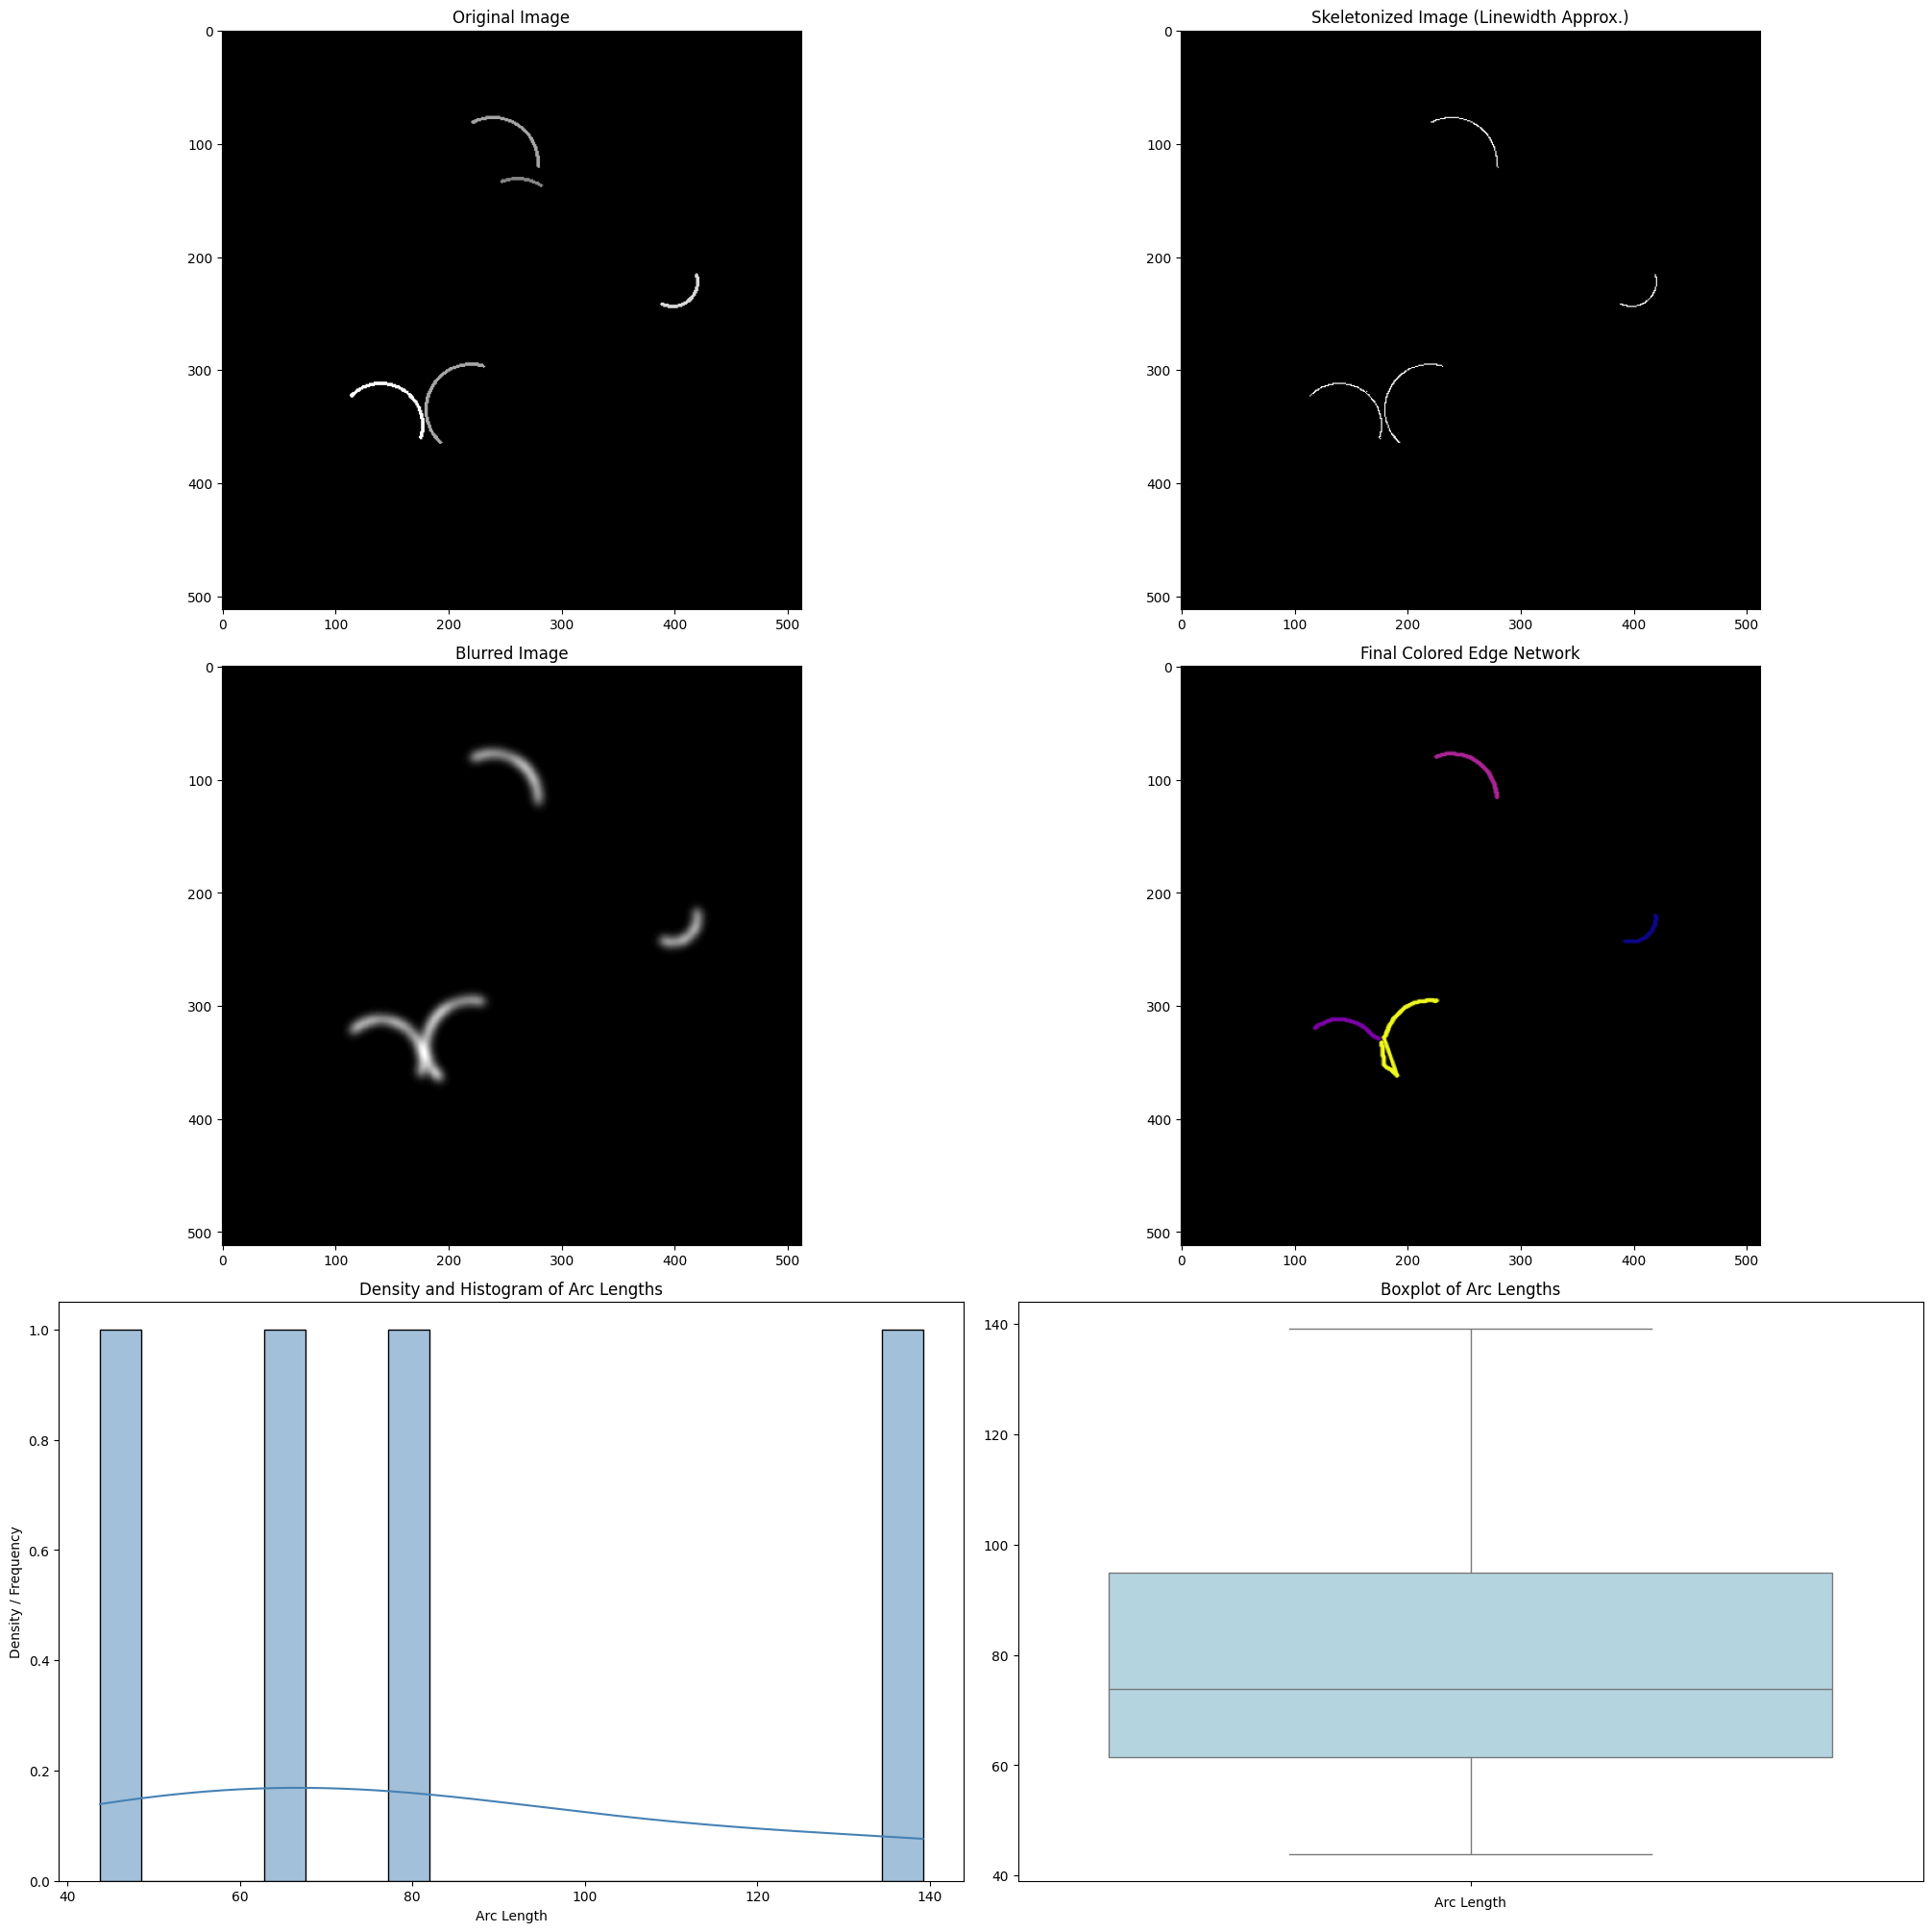

Number of branch points: 1
Number of Intersection Associations: 1
Number of Branch Connections:  1
Average Fiber Length: 82.63698324561119


In [48]:
# Load image data as raw binary data
with open("image_1.png", "rb") as f:
    raw_data = f.read()

# Convert raw binary data to a NumPy array and decode
img_data = np.frombuffer(raw_data, dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 3750)

Preprocessing Image
Time Elapsed: 1.2937 sec
Finding branch points
Time Elapsed: 0.0075 sec
Finding edge segments
Removed 104 small contours (less than 5 points or arc length)
Time Elapsed: 0.0413 sec
Finding Intersection to Edge Associations
Time Elapsed: 4.7515 sec
Deciding which edges to merge
Time Elapsed: 0.5262 sec
Merging Edges
Time Elapsed: 0.2750 sec
Creating Visualization and calculating 447 arc lengths


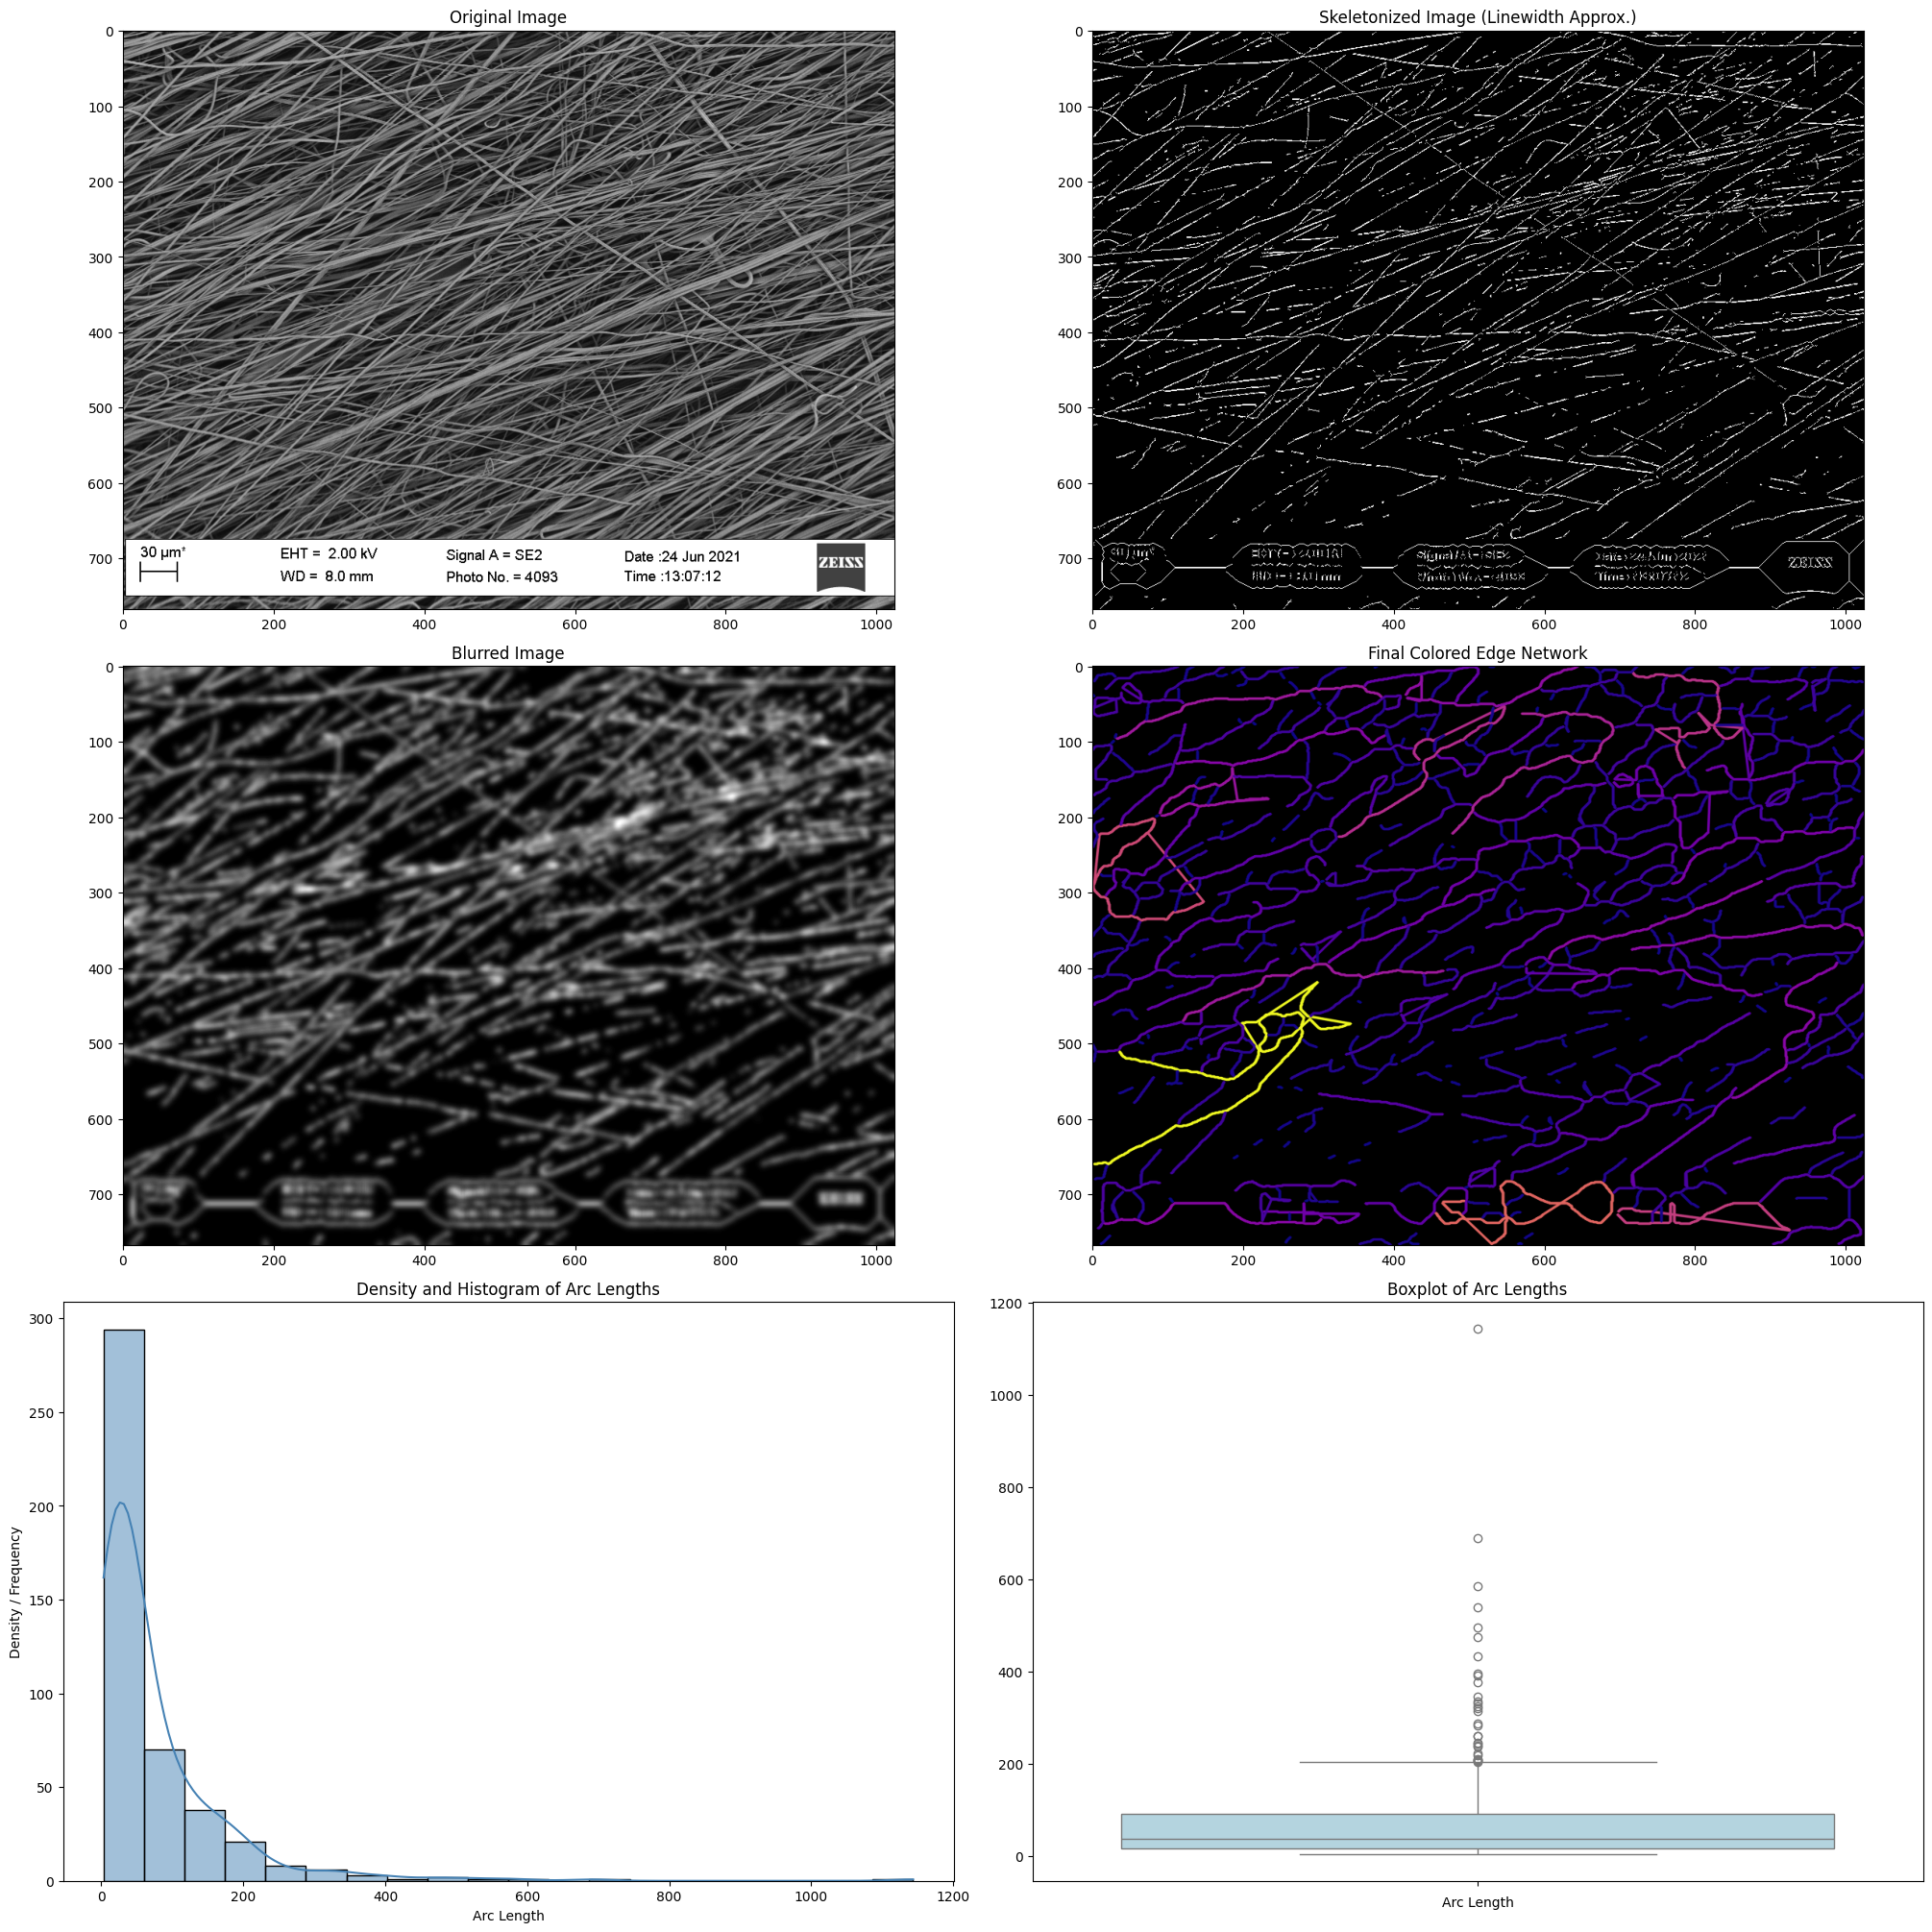

Number of branch points: 633
Number of Intersection Associations: 633
Number of Branch Connections:  617
Average Fiber Length: 73.86309217153246


In [ ]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/PCLgel_2to1_align_500x_12.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 3750)

Preprocessing Image
Time Elapsed: 1.1833 sec
Finding branch points
Time Elapsed: 0.0069 sec
Finding edge segments
Removed 120 small contours (less than 5 points or arc length)
Time Elapsed: 0.0284 sec
Finding Intersection to Edge Associations
Time Elapsed: 4.0971 sec
Deciding which edges to merge
Time Elapsed: 0.4990 sec
Merging Edges
Time Elapsed: 0.2863 sec
Creating Visualization and calculating 402 arc lengths


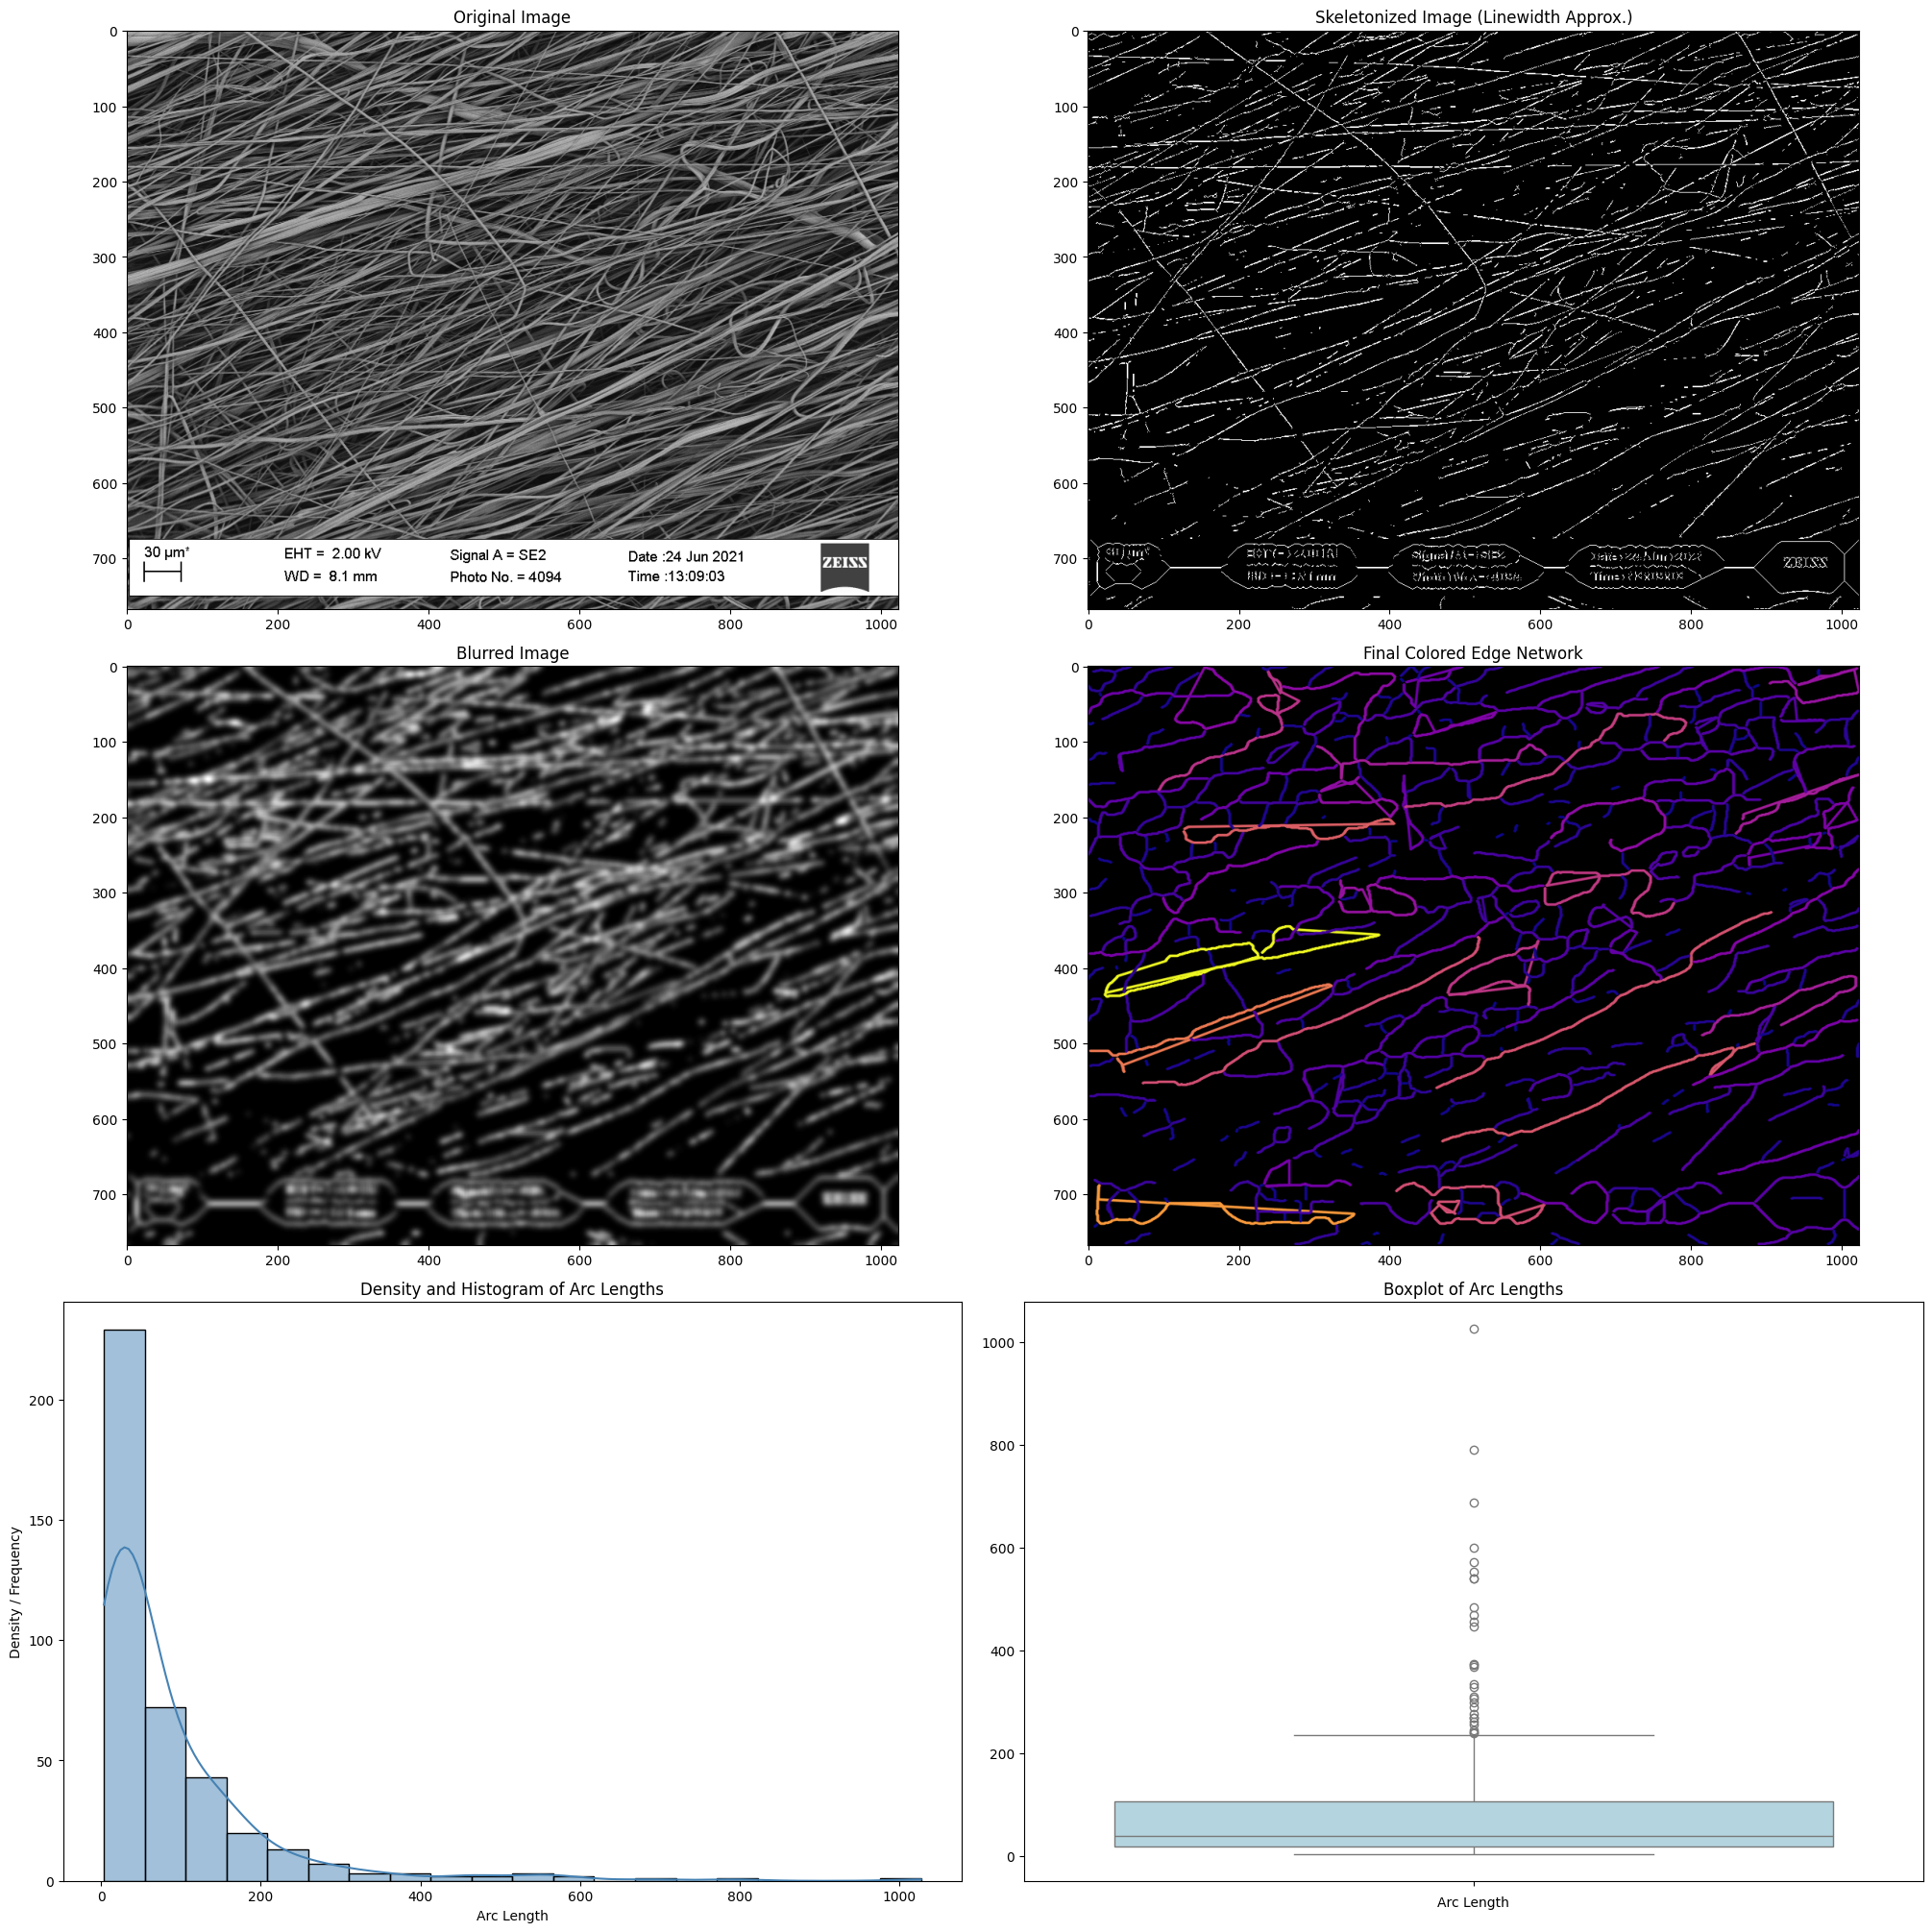

Number of branch points: 601
Number of Intersection Associations: 601
Number of Branch Connections:  583
Average Fiber Length: 84.68474729470353


In [ ]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/PCLgel_2to1_align_500x_13.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 3750)

Preprocessing Image
Time Elapsed: 1.2076 sec
Finding branch points
Time Elapsed: 0.0069 sec
Finding edge segments
Removed 105 small contours (less than 5 points or arc length)
Time Elapsed: 0.0328 sec
Finding Intersection to Edge Associations
Time Elapsed: 4.6943 sec
Deciding which edges to merge
Time Elapsed: 0.4879 sec
Merging Edges
Time Elapsed: 0.2731 sec
Creating Visualization and calculating 453 arc lengths


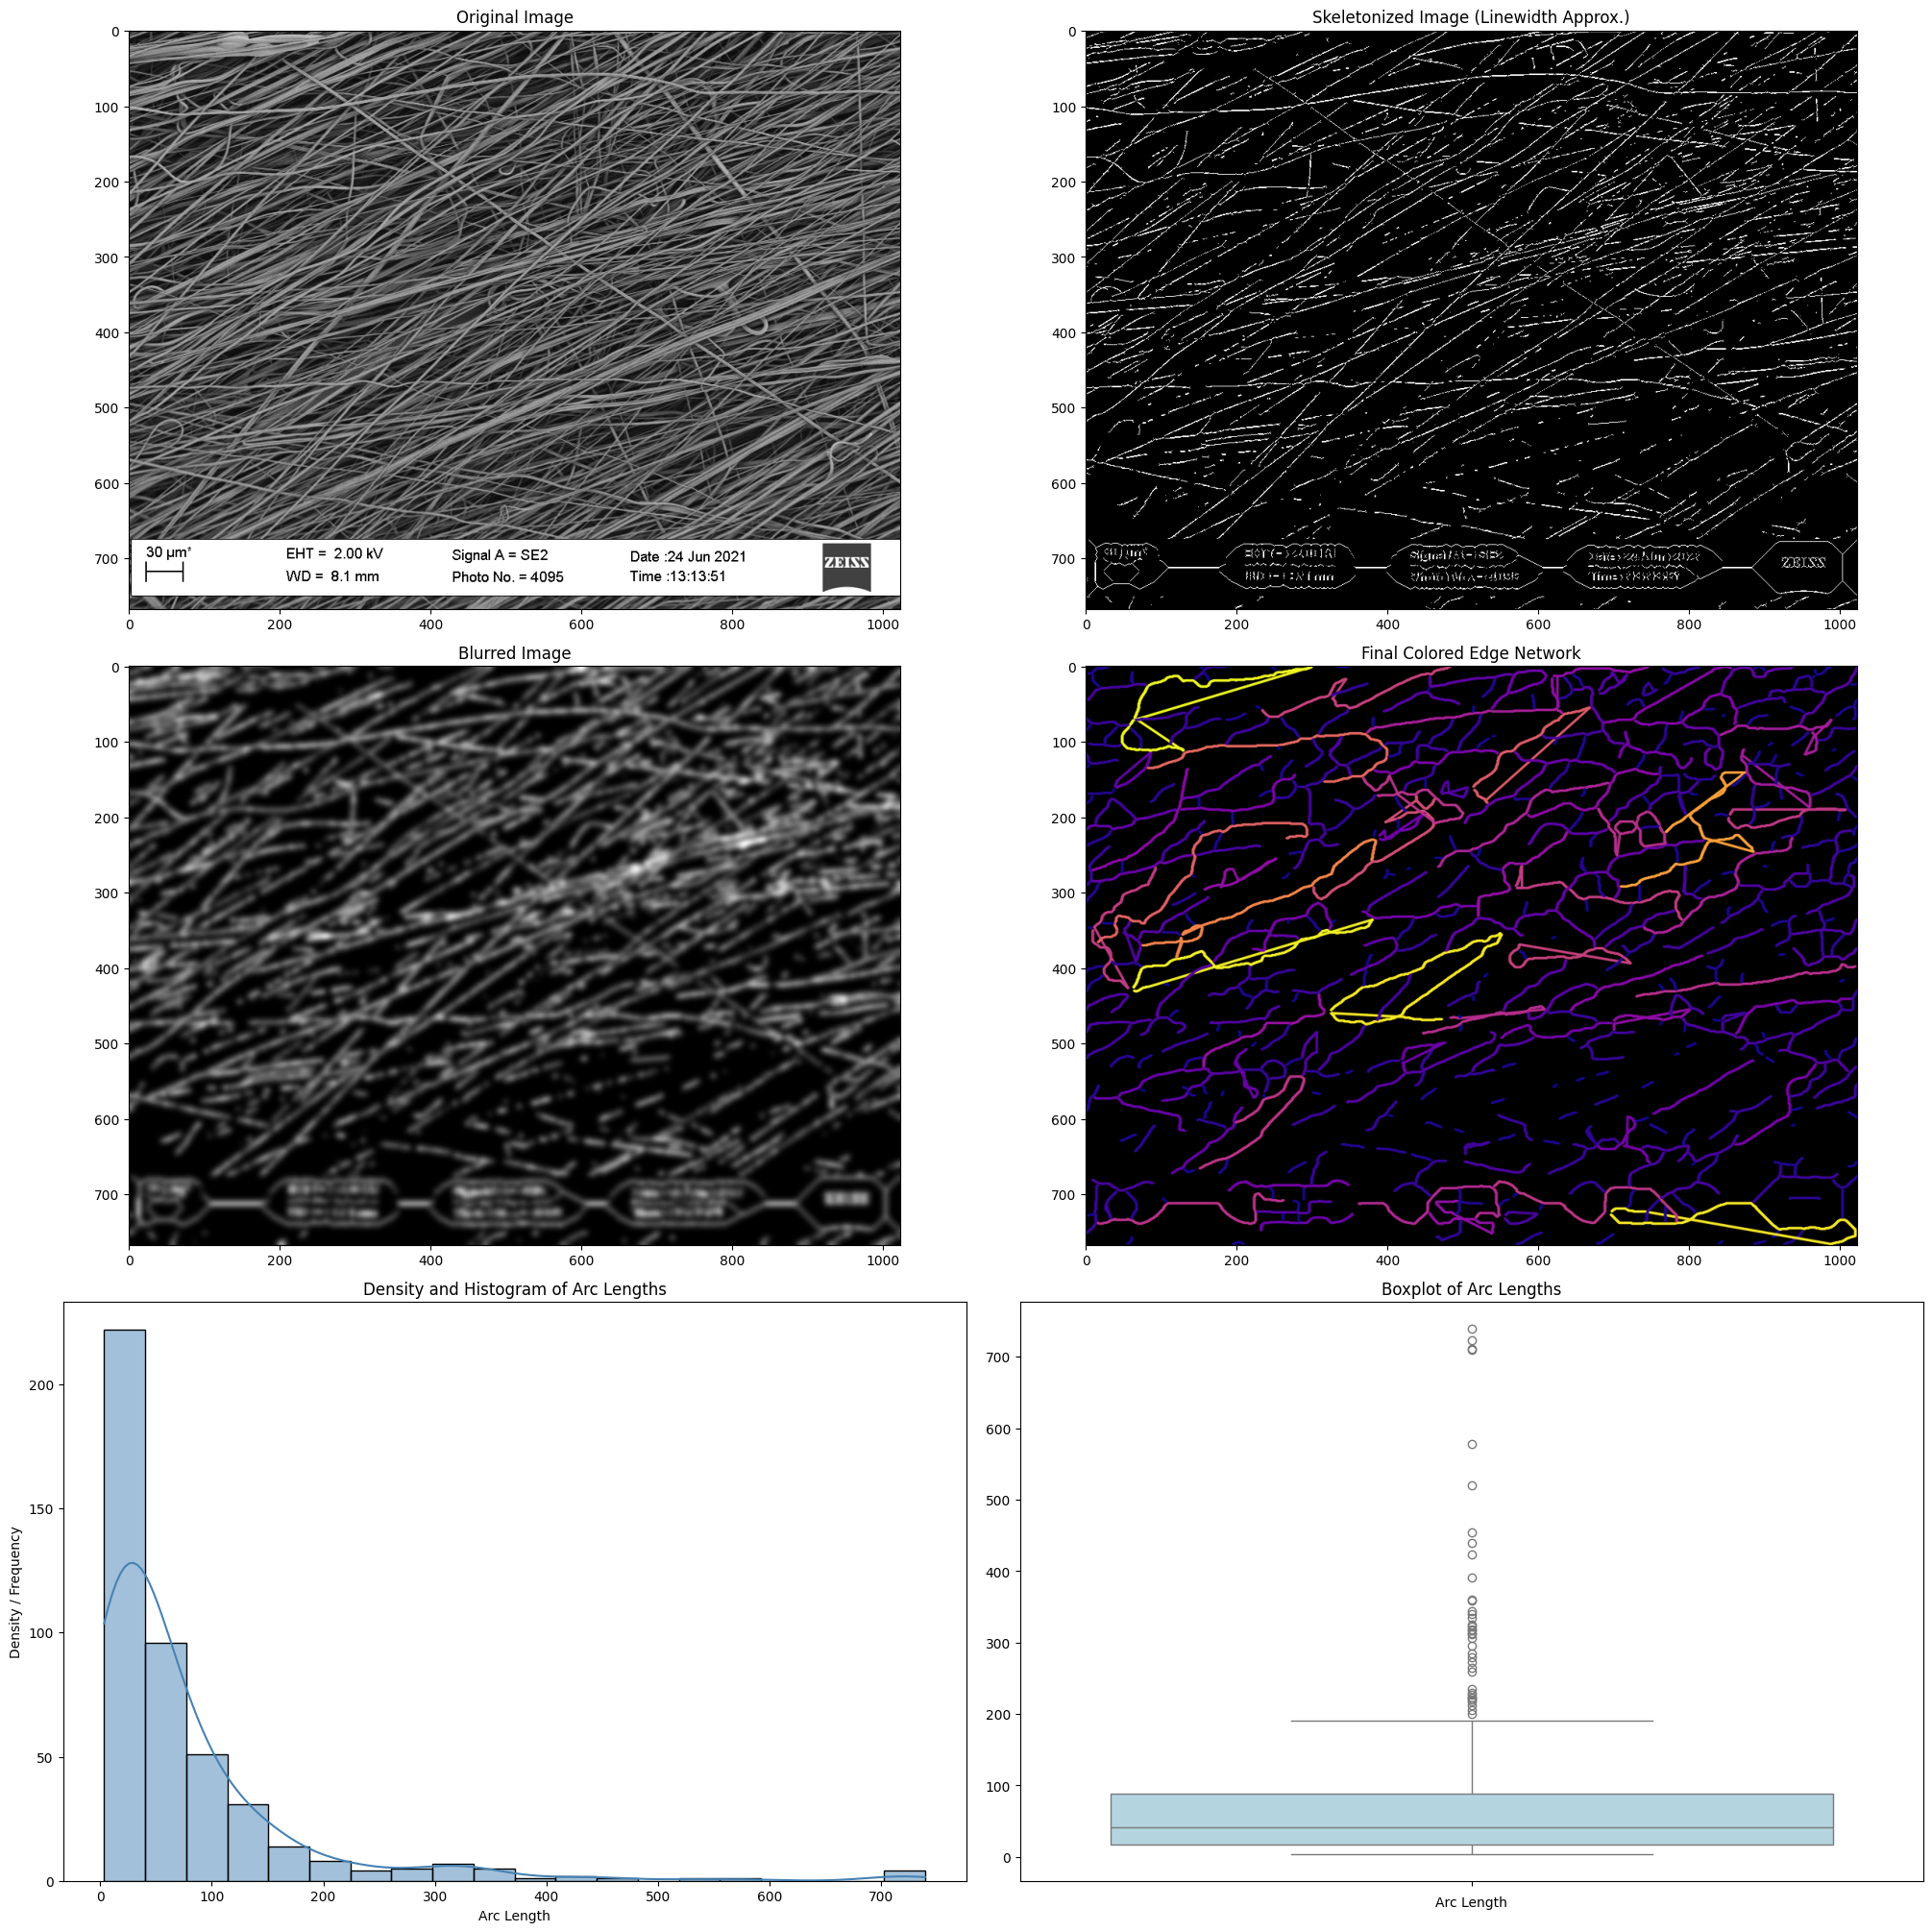

Number of branch points: 627
Number of Intersection Associations: 627
Number of Branch Connections:  613
Average Fiber Length: 75.72477333671999


In [ ]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/PCLgel_2to1_align_500x_14.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 3750)